<!-- This cell is automatically updated by tools/tutorial-cell-updater.py -->
<!-- The contents are initialized from tutorials/notebook-header.md -->

[<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>](https://colab.research.google.com/github/speechbrain/speechbrain/blob/develop/docs/tutorials/advanced/model-quantization.ipynb)
to execute or view/download this notebook on
[GitHub](https://github.com/speechbrain/speechbrain/tree/develop/docs/tutorials/advanced/model-quantization.ipynb)

# Applying Quantization to a Speech Recognition Model

## Introduction to Quantization

Quantization is often required for low latency applications of SpeechBrain automatic speech recognition models, such as real-time speech recognition.

Quantization works by converting the weights and activations of a model from floating point values into lower resolution values, such as 8-bit integers. Not only does this reduce the memory footprint of the model, but it also reduces inference latency, because integer operations are typically faster than floating point operations.

This conversion works by mapping values in a given range to the quantized range and "clipping" values to the closest value at the chosen resolution. In general, there are two main concepts associated with quantization: zero point and scale factor.

- Zero point: the quantized value that 0 is mapped to during quantization.

- Scale factor: the factor by which the data range is scaled to fit within the quantized range.

Put together, the zero point and scale factor describe how the mapping works.

In other words,

$y = round\left(\frac{x}{S} + Z\right)$

where $x$ is the original value, $y$ is the quantized value, $S$ is the scale factor, and $Z$ is the zero point.

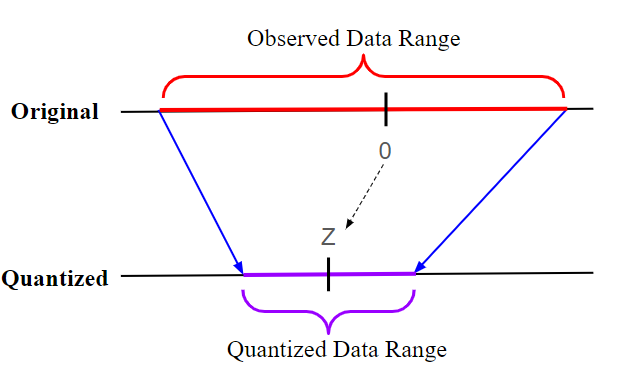

## Quantization Approaches

Quantization can be categorized based on *when* the quantization happens: in quantization-aware training (QAT), quantization is incorporated during training, whereas in post-training quantization (PTQ), quantization is applied only after the model has been trained. This tutorial's emphasis is on quantizing pretrained models, which means it will focus on the latter.

PTQ can be further subdivided into two approaches based on when the activations of a model are quantized. Dynamic quantization does so during model inference, while static quantization does so before inference happens.

For all types of quantization, weights can be quantized beforehand, because weights are dependent on the model itself and not on input data. This means that information about the range of weight values is already available at the time of quantization, allowing weights to be quantized without requiring any further information.

However, activations of models, i.e. the values after applying activation functions, are dependent on input data. This means that the range of activation values is subject to change during runtime, which motivates the different approaches to quantization.

### Dynamic Quantization

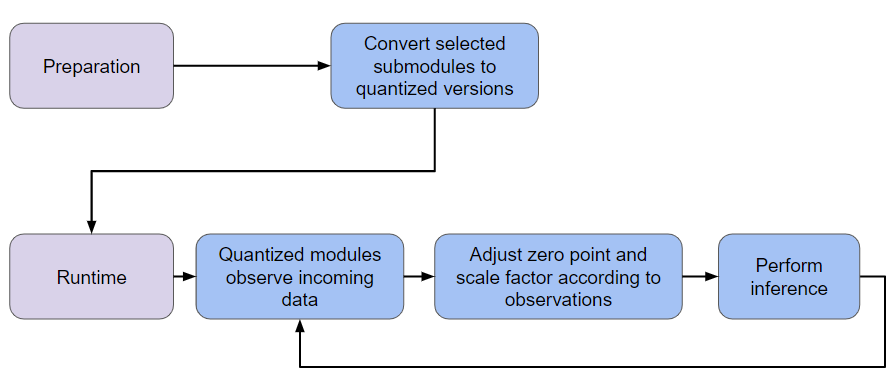

In dynamic quantization, submodules are converted to quantized versions during the preparation stage, such that the weights are appropriately quantized. Then, during inference, each quantized layer observes the data that is fed into it, and adjusts the quantization parameters according to what is observed. This happens repeatedly as inference is carried out, hence the name, 'dynamic' quantization.

### Static Quantization

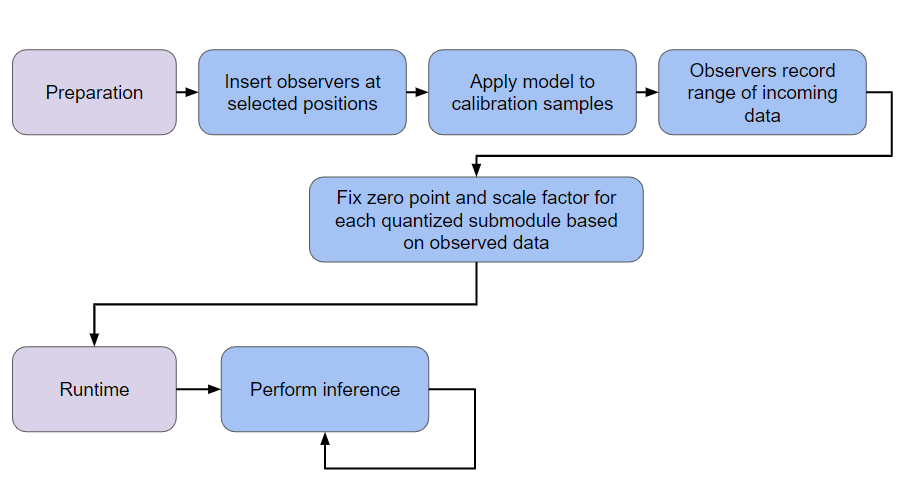

In contrast to dynamic quantization, static quantization does not perform any adjustments during runtime. Instead, observer modules are inserted at selected positions where layers will be quantized, and the model is applied to a representative set of data samples. The observer modules will then select quantization parameters based on the data that has been fed into the model, and these parameters will remain fixed during runtime.

### *Comparing Dynamic and Static Quantization*

Dynamic quantization does not fix the zero point and scale factor, but rather adjusts it in response to the data observed during runtime. In contrast, the static quantization requires an initial calibration stage. During calibration for static quantization, observer modules will record the data range of the activations and use it to determine the zero point and scale factor.

The advantage of dynamic quantization is that it does not require calibration and is suitable for modules that can have large variances in their input data range. On the other hand, static quantization does not need to perform on-the-fly quantization adjustments during runtime, which can potentially reduce latency, but this can come at the cost of lower accuracy.

## Purpose of Tutorial

This tutorial will show how to adapt PyTorch quantization functions so that they can be applied to SpeechBrain models, as well as how the quantized models can be benchmarked.

The tutorial will focus on pretrained automatic speech recognition (ASR) models, which can be easily loaded and used using the `speechbrain.inference.ASR` module in the library.

## Prerequisites

### Install SpeechBrain

In [ ]:
%%capture
# Installing SpeechBrain via pip
BRANCH = 'develop'
!python -m pip install git+https://github.com/speechbrain/speechbrain.git@$BRANCH

### Install Other Dependencies

`kenlm` and `pygtrie` are external libraries that our chosen model relies on for n-gram related functionality. If your model does not use these libraries, you may not need these. Replace these installations with other external libraries that your model needs.

In [ ]:
%%capture
!pip install https://github.com/kpu/kenlm/archive/master.zip
!pip install pygtrie

### Imports

In [ ]:
import gc
import numpy as np
import os
import sentencepiece
import speechbrain
import time
import torch
import torch.nn as nn
import tqdm

from collections import Counter
from copy import deepcopy

### Model Selection

For the purposes of this tutorial, we will be using a Wav2Vec 2.0 model with CTC trained on CommonVoice English.

Wav2Vec 2.0 models are transformer-based. In addition, this is an Encoder ASR model, meaning that it does not have a decoder layer, but instead uses a decoding function. While the encoder does not use a language model, the decoding function optionally uses a language model for n-gram rescoring, which is why kenlm needs to be installed.

In [ ]:
from speechbrain.inference.ASR import EncoderASR

asr_model = EncoderASR.from_hparams(
    source="speechbrain/asr-wav2vec2-commonvoice-14-en",
    savedir="/content/pretrained_ASR/asr-wav2vec2-commonvoice-14-en",
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-large-lv60 and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Let us take a closer look at the submodules of the model.

In [ ]:
asr_model

EncoderASR(
  (mods): ModuleDict(
    (encoder): LengthsCapableSequential(
      (wav2vec2): Wav2Vec2(
        (model): Wav2Vec2Model(
          (feature_extractor): Wav2Vec2FeatureEncoder(
            (conv_layers): ModuleList(
              (0): Wav2Vec2LayerNormConvLayer(
                (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
                (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
                (activation): GELUActivation()
              )
              (1-4): 4 x Wav2Vec2LayerNormConvLayer(
                (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
                (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
                (activation): GELUActivation()
              )
              (5-6): 2 x Wav2Vec2LayerNormConvLayer(
                (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
                (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
                (activati

Note that not all modules can be quantized, and some modules cannot be quantized with certain methods. In particular, note the following list of modules that can be quantized without needing custom modifications to get around PyTorch's limitations:

Dynamically quantizable modules
* `nn.Linear`
* `nn.LSTM`
* `nn.GRU`
* `nn.RNNCell`
* `nn.GRUCell`
* `nn.LSTMCell`
* `nn.EmbeddingBag`
* `nn.Embedding`

Statically quantizable modules
* `nn.Linear`
* `nn.Conv1d/2d/3d`
* `nn.EmbeddingBag`
* `nn.Embedding`

Armed with this information, we can start to pinpoint our quantization scheme. From our chosen model, we can identify the following modules:
* `encoder.wav2vec2.model.feature_extractor`: contains 7 `nn.Conv1d` layers, which must be statically quantized.

* `encoder.wav2vec2.model.feature_projection`: contains 1 `nn.Linear` layer, which can be quantized both dynamically and statically.

* `encoder.wav2vec2.model.encoder.pos_conv_embed`: contains an `nn.ParameterizedConv1d` layer, for which quantization has not been implemented in PyTorch.

*  `encoder.wav2vec2.model.encoder.layers`: static quantization has not been properly implemented for modules that rely on attention, such as this submodule, which contains transformer layers, so only dynamic quantization can be applied.

* `encoder.enc`: a sequence of `nn.Linear` and `nn.BatchNorm1d` layers. Unfortunately, PyTorch does not allow BatchNorm layers to be statically quantized if they do not come after convolutional layers, so this submodule must be dynamically quantized.

* `encoder.ctc_lin`: contains 1 `nn.Linear` layer, which can be either dynamically or statically quantized.

Note that we have just separated out the "main" submodules of the model - it is possible to quantize in an even more granular manner by applying different quantization strategies to specific layers within the submodules we have picked out. (For example, we could apply static quantization to a specific `nn.Linear` layer inside `encoder.wav2vec2.model.encoder.layers`, even if the entire submodule cannot be quantized in such a manner.)

However, there is an overhead to quantization, because inputs have to be quantized and outputs have to be dequantized, so it is unadvisable to perform quantization in too granular of a manner. For example, statically quantizing multiple layers at the same time means only one quantization and one dequantization are needed, whereas quantizing them separately would mean performing dequantization and quantization repeatedly as data flows from one layer to the other.

Given the restrictions on quantization, as well as empirically collected data, for this model we will dynamically quantize `encoder.wav2vec2.model.encoder.layers` and `encoder.enc`, and statically quantize `encoder.wav2vec2.model.feature_extractor` and `encoder.wav2vec2.model.feature_projection`.

`encoder.ctc_lin` will not be quantized, because experiments show that it has a large impact on WER (word error rate, a measure of accuracy) if it is quantized.

Since submodules respond differently to different quantization methods, you may have to experiment with a combination of dynamic and static combination in order to find the combination that best suits your model.

### Data Download and Preprocessing

Download the LibriSpeech dev-clean dataset, which contains audio samples and corresponding transcriptions. This will be the dataset we use for evaluating the performance of the model before and after quantization. This dataset is chosen because it is relatively small---we do not need a large dataset for evaluating the performance of the model---and because it is clean, i.e. there are no background noise or audio artifacts that may unnecessarily interfere with the model's accuracy.

Additional preprocessing is needed to convert the dataset into a format suitable for applying our models to, as well as for comparing the output of the models to the reference transcription. We want to have a list of audio-reference pairs in order to compare the output of the model on each audio sample to the correct reference transcription.

In [ ]:
%%capture
!mkdir librispeech_dev_clean
!wget https://www.openslr.org/resources/12/dev-clean.tar.gz -P /content
!tar -xvf dev-clean.tar.gz -C librispeech_dev_clean

In [ ]:
from speechbrain.dataio.dataio import read_audio

# Retrieve the downloaded speech data as a list of audio-reference pairs
def get_samples(root):
    audios = []
    references = []
    for book in os.listdir(root):
        for chapter in os.listdir(f"{root}/{book}"):
            for file in os.listdir(f"{root}/{book}/{chapter}"):
                if file.endswith("txt"):
                    with open(f"{root}/{book}/{chapter}/{file}", "r") as f:
                        for line in f.readlines():
                            audio_path, reference = line.split(" ", 1)
                            full_audio_path = f"{root}/{book}/{chapter}/{audio_path}.flac"
                            audios.append(read_audio(full_audio_path))
                            references.append(reference)
    return audios, references


In [ ]:
audios, references = get_samples("/content/librispeech_dev_clean/LibriSpeech/dev-clean")
assert len(audios) == len(references)

## Quantization Set-Up

### Utility Functions

Here we define `get_module` and `set_module`, utility functions that are used to retrieve and set submodules within a module by providing the string. This is necessary in order to perform localized quantization, i.e. to replace a submodule with a quantized submodule without quantizing anything else.

The utility functions build on the `getattr` and `setattr` functions, but enable nested attributes to be used, e.g.

```
module_string = "encoder.wav2vec2.model.feature_projection"
```

This allows nested submodules to be retrieved and set.

In [ ]:
def get_module(model, module_string):
    curr = model.mods
    for attr in module_string.split("."):
        if attr.isnumeric():
            curr = curr[int(attr)]
        else:
            curr = getattr(curr, attr)
    return curr

def set_module(model, module_string, new_module):
    curr = model.mods
    attrs = module_string.split(".")
    for attr in attrs[:-1]:
        if attr.isnumeric():
            curr = curr[int(attr)]
        else:
            curr = getattr(curr, attr)
    if attrs[-1].isnumeric():
        curr[int(attrs[-1])] = new_module
    else:
        setattr(curr, attrs[-1], new_module)

### Static Quantization Wrapper

Static quantization requires the `QuantStub` and `DeQuantStub` modules to indicate the boundaries between quantized and unquantized modules, as well as to indicate where quantization observers should be placed for calibration.

During calibration, quantization observers will record the range of data in order to determine the scale factor and zero point of quantization, so as to achieve a more optimal quantization result.

Furthermore, upon static quantization, `QuantStub` and `DeQuantStub` will be converted to layers that quantize and dequantize incoming tensors respectively, allowing quantized modules to smoothly interface with unquantized modules.

Notice below that `__getattr__` is overridden in order to allow attributes referencing the model inside the wrapper to be retrieved.

Also, `DeQuantStub` must be able to deal with tuples returned from the model, i.e. multiple return values, because on its own the forward function of `DeQuantStub` does not account for tuples.

In [ ]:
from torch.ao.quantization import QuantStub, DeQuantStub

class StaticQuant(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.quant = QuantStub()
        self.model = model
        self.dequant = DeQuantStub()

    def __getattr__(self, name):
        if name in self.__dict__:
            return self.__dict__[name]
        elif name in self.__dict__['_modules']:
            return self.__dict__['_modules'][name]
        else:
            return getattr(self.__dict__['_modules']['model'], name)

    def forward(self, x, *args, **kwargs):
        x = self.quant(x)
        x = self.model(x, *args, **kwargs)
        if isinstance(x, tuple):
            return tuple(self.dequant(output) for output in x)
        else:
            return self.dequant(x)


### Quantization Function

This is a custom quantization function that enables submodules to be quantized both dynamically and statically. It also offers additional flexibility by allowing hyperparameters such as the resolution of quantization and other quantization configurations to be applied. This allows for simpler application of a combination of quantization strategies to our model.

See the docstring for details.

In [ ]:
def custom_quantize(
        model,
        dynamic_modules=None,
        static_modules=None,
        calibration_samples=None,
        dynamic_targets=None,
        dynamic_dtype=torch.qint8,
        static_qconfig=torch.ao.quantization.default_qconfig,
):
    """Performs in-place quantization of an ASR model

    The quantization is customizable. A combination of dynamic and static
    quantization can be performed on specific submodules that are passed into
    this function.

    Names of submodules passed into this class are implicitly assumed to be
    nested fields of ``model.mods``. For example, the ``model.mods.encoder.enc``
    submodule should be passed in as ``encoder.enc``.

    Reference https://pytorch.org/docs/stable/quantization.html for
    what torch modules can and cannot be dynamically/statically quantized.

    Arguments
    ---------
    model : torch.nn.Module
        Model to be quantized.
    dynamic_modules : list[str]
        Names of the submodules to be dynamically quantized. They should be
        formatted as stated above.
    static_modules : list[str]
        Names of the submodules to be statically quantized. They should be
        formatted as stated above.'
    calibration_samples : list[torch.Tensor]
        Sample inputs used for calibration during static quantization.
    dynamic_targets : set[torch.nn.Module]
        Torch modules to be quantized during dynamic quantization.
    dynamic_dtype : torch.dtype
        The torch datatype that values will be converted to during dynamic
        quantization. This should be a quantized datatype, such as
        ``torch.quint8``, ``torch.qint8``, ``torch.qint32``
    static_qconfig : torch.ao.quantization.qconfig.QConfig
        The quantization config for static quantization, which, among other
        things, specifies the observer modules that will be inserted
        and the resolution of quantization.

    Returns
    -------
    None
    """

    ##################################################
    # Dynamic Quantization                           #
    ##################################################
    if dynamic_modules is not None and len(dynamic_modules) > 0:
        if dynamic_targets is None:
            dynamic_targets = {
                torch.nn.LSTM,
                torch.nn.GRU,
                torch.nn.RNNCell,
                torch.nn.GRUCell,
                torch.nn.LSTMCell,
                torch.nn.Linear
            }

        for module in dynamic_modules:
            torch.quantization.quantize_dynamic(
                get_module(model, module),
                dynamic_targets,
                dtype=dynamic_dtype,
                inplace=True,
            )

    ##################################################
    # Static Quantization                            #
    ##################################################
    if static_modules is not None and len(static_modules) > 0:
        if calibration_samples is None or len(calibration_samples) == 0:
            raise Exception("No calibration samples provided for static quantization.")

        for module in static_modules:
            set_module(
                model,
                module,
                StaticQuant(get_module(model, module)),
            )
            get_module(model, module).qconfig = static_qconfig

        torch.ao.quantization.prepare(model, inplace=True)

        for sample in calibration_samples:
            model.transcribe_batch(sample.unsqueeze(0), torch.tensor([1.0]))

        torch.ao.quantization.convert(model, inplace=True)


## Benchmarking Set-Up

We will focus on the two main performance metrics for ASRs, real-time factor (RTF) and word error rate (WER).

RTF is the ratio of the total inference time to the total length of the input audio. This is significant because an RTF lower than 1 implies that inference takes less time than it takes to play the audio, which potentially allows for real time speech recognition (excluding other sources of latency).

WER is the ratio of the number of word-level errors (substitutions, deletions, insertions) made by the model to the number of words in the reference.

Put together, these two metrics allow us to assess the latency and accuracy of the model before and after quantization.

### WER

Levenshtein distance, or edit distance, is at the core of the WER metric. It measures the number of substitutions, deletions, and/or insertions needed to transform one string to another, which can be computed using a dynamic programming approach.

The main difference between Levenshtein distance and WER is that the former considers strings on a character level, while the latter considers the substitution/deletion/insertion of entire words.

Speechbrain provides utility functions to measure WER and other related metrics.

In [ ]:
from speechbrain.utils.edit_distance import accumulatable_wer_stats

def compute_wer(references, hypotheses):
    if isinstance(references, str):
        references = [references.split()]
    else:
        references = [ref.split() for ref in references]
    if isinstance(hypotheses, str):
        hypotheses = [hypotheses.split()]
    else:
        hypotheses = [hyp.split() for hyp in hypotheses]
    if len(references) != len(hypotheses):
        raise Exception("Number of references is not equal to the number of hypotheses")
    stats = accumulatable_wer_stats(references, hypotheses, Counter())
    return stats['WER']


### Modify EncoderASR transcribe_batch

Modify the existing `transcribe_batch` method in order to time the encoder's forward function.

Different ASR types have different `transcribe_batch` implementations, so small tweaks may need to be carried out as appropriate for your own model.

In [ ]:
import functools

# Functions necessary for preprocessing the input and generating transcriptions

def preprocess_input(model: EncoderASR, input):
    with torch.no_grad():
        wavs = input.unsqueeze(0)
        wav_lens = torch.tensor([1.0])
        wavs = wavs.float()
        wavs, wav_lens = wavs.to(model.device), wav_lens.to(model.device)
        return wavs, wav_lens

def generate(model, predictions):
    is_ctc_text_encoder_tokenizer = isinstance(
        model.tokenizer, speechbrain.dataio.encoder.CTCTextEncoder
    )
    if isinstance(model.hparams.decoding_function, functools.partial):
        if is_ctc_text_encoder_tokenizer:
            predicted_words = [
                "".join(model.tokenizer.decode_ndim(token_seq))
                for token_seq in predictions
            ]
        else:
            predicted_words = [
                model.tokenizer.decode_ids(token_seq)
                for token_seq in predictions
            ]
    else:
        predicted_words = [hyp[0].text for hyp in predictions]
    return predicted_words


Note that we are only interested in the change in inference time relevant to quantization, and not the overhead of input preprocessing or word generation. This is why we only record the duration of the encoder's forward function.

In [ ]:
def timed_transcribe(model: EncoderASR, input):
    with torch.no_grad():
        wavs, wav_lens = preprocess_input(model, input)
        start = time.time()
        encoder_out = model.mods.encoder(wavs, wav_lens)
        end = time.time()
        duration = end - start
        predictions = model.decoding_function(encoder_out, wav_lens)
        predicted_words = generate(model, predictions)
    return predicted_words[0], duration


### Benchmark Model Performance

Latency measurement is often unstable at first, so a warmup phase is introduced in order to ensure a more accurate performance evaluation.

In [ ]:
def benchmark(model, samples, references):
    total_audio_length = sum([sample.shape[0] / 16000 for sample in samples])
    total_cpu_time = 0
    outputs = []

    for sample in tqdm.tqdm(samples[:10], desc="warming up"):
        timed_transcribe(model, sample)

    for sample in tqdm.tqdm(samples, desc="evaluating"):
        output, duration = timed_transcribe(model, sample)
        outputs.append(output)
        total_cpu_time += duration

    wer = compute_wer(references, outputs)
    rtf = total_cpu_time / total_audio_length
    return wer, rtf


## Quantization and Benchmarking

With the necessary set-up code for quantization and benchmarking in place, we can start to actually benchmark our model before and after quantization.

### Select Data

For the sake of time, select a subset of the audio data for benchmarking the models.

In [ ]:
n = 100
audio_subset = audios[:n]
ref_subset = references[:n]

### Original Model

In [ ]:
# Deepcopy the original model to avoid propagating unwanted changes
original_model = deepcopy(asr_model)

In [ ]:
original_model.eval()
wer, rtf = benchmark(original_model, audio_subset, ref_subset)

evaluating: 100%|██████████| 100/100 [09:32<00:00,  5.73s/it]


In [ ]:
print(f"Original Model\nWER(%): {wer}\nRTF: {rtf}")

Original Model
WER(%): 6.067291781577496
RTF: 0.7967449480673793


To avoid exceeding the session's RAM limit, delete models after benchmarking.

In [ ]:
del original_model
gc.collect()

0

### Quantized Model

First, let us recall the model architecture:

In [ ]:
asr_model

EncoderASR(
  (mods): ModuleDict(
    (encoder): LengthsCapableSequential(
      (wav2vec2): Wav2Vec2(
        (model): Wav2Vec2Model(
          (feature_extractor): Wav2Vec2FeatureEncoder(
            (conv_layers): ModuleList(
              (0): Wav2Vec2LayerNormConvLayer(
                (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
                (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
                (activation): GELUActivation()
              )
              (1-4): 4 x Wav2Vec2LayerNormConvLayer(
                (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
                (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
                (activation): GELUActivation()
              )
              (5-6): 2 x Wav2Vec2LayerNormConvLayer(
                (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
                (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
                (activati

As previously mentioned, for this tutorial we will apply dynamic quantization to the attention layers and sequential linear layers, and static quantization to the other quantizable layers (excluding `ctc_lin`, which has been experimentally observed to respond poorly to quantization).

Recall that not all PyTorch layers can be quantized, and some can only be quantized dynamically or statically, so there are restrictions on your choice of modules to quantize and method of quantization.

For your model, feel free to experiment with what yields the best results.

In [ ]:
dynamic_modules = [
    "encoder.wav2vec2.model.encoder.layers",
    "encoder.enc"
]
static_modules = [
    "encoder.wav2vec2.model.feature_projection",
    "encoder.wav2vec2.model.feature_extractor",
]

Randomly select calibration samples for use in static quantization.

In [ ]:
from operator import itemgetter

np.random.seed(1337)
indices = np.random.choice(len(audios), 10)
calibration_samples = list(itemgetter(*indices)(audios))

We have what we need to quantize the model.

In [ ]:
# Deepcopy the original model to avoid propagating unwanted changes
quantized_model = deepcopy(asr_model)

In [ ]:
custom_quantize(
    model=quantized_model,
    dynamic_modules=dynamic_modules,
    static_modules=static_modules,
    calibration_samples=calibration_samples,
)

Here is the model after quantization. Notice how the specified submodules have been replaced with quantized versions.

In [ ]:
quantized_model

EncoderASR(
  (mods): ModuleDict(
    (encoder): LengthsCapableSequential(
      (wav2vec2): Wav2Vec2(
        (model): Wav2Vec2Model(
          (feature_extractor): Static(
            (quant): Quantize(scale=tensor([0.1671]), zero_point=tensor([60]), dtype=torch.quint8)
            (model): Wav2Vec2FeatureEncoder(
              (conv_layers): ModuleList(
                (0): Wav2Vec2LayerNormConvLayer(
                  (conv): QuantizedConv1d(1, 512, kernel_size=(10,), stride=(5,), scale=0.23443543910980225, zero_point=67)
                  (layer_norm): QuantizedLayerNorm((512,), eps=1e-05, elementwise_affine=True)
                  (activation): GELUActivation()
                )
                (1): Wav2Vec2LayerNormConvLayer(
                  (conv): QuantizedConv1d(512, 512, kernel_size=(3,), stride=(2,), scale=0.8026854991912842, zero_point=62)
                  (layer_norm): QuantizedLayerNorm((512,), eps=1e-05, elementwise_affine=True)
                  (activation): GELUAc

Next, we benchmark the quantized model.

In [ ]:
quantized_model.eval()
wer, rtf = benchmark(quantized_model, audio_subset, ref_subset)

evaluating: 100%|██████████| 100/100 [07:12<00:00,  4.32s/it]


In [ ]:
print(f"Quantized Model\nWER(%): {wer}\nRTF: {rtf}")

Quantized Model
WER(%): 7.335907335907336
RTF: 0.6004914075674289


We can observe a significant decrease in RTF with a reasonable increase in WER. This shows that the quantization has been successful.

Finally, if you need to do any more quantization benchmarking with other models, you may delete this one to free up RAM.

In [ ]:
del quantized_model
gc.collect()

4479

## Citing SpeechBrain

If you use SpeechBrain in your research or business, please cite it using the following BibTeX entry:

```bibtex
@misc{speechbrainV1,
  title={Open-Source Conversational AI with {SpeechBrain} 1.0},
  author={Mirco Ravanelli and Titouan Parcollet and Adel Moumen and Sylvain de Langen and Cem Subakan and Peter Plantinga and Yingzhi Wang and Pooneh Mousavi and Luca Della Libera and Artem Ploujnikov and Francesco Paissan and Davide Borra and Salah Zaiem and Zeyu Zhao and Shucong Zhang and Georgios Karakasidis and Sung-Lin Yeh and Pierre Champion and Aku Rouhe and Rudolf Braun and Florian Mai and Juan Zuluaga-Gomez and Seyed Mahed Mousavi and Andreas Nautsch and Xuechen Liu and Sangeet Sagar and Jarod Duret and Salima Mdhaffar and Gaelle Laperriere and Mickael Rouvier and Renato De Mori and Yannick Esteve},
  year={2024},
  eprint={2407.00463},
  archivePrefix={arXiv},
  primaryClass={cs.LG},
  url={https://arxiv.org/abs/2407.00463},
}
@misc{speechbrain,
  title={{SpeechBrain}: A General-Purpose Speech Toolkit},
  author={Mirco Ravanelli and Titouan Parcollet and Peter Plantinga and Aku Rouhe and Samuele Cornell and Loren Lugosch and Cem Subakan and Nauman Dawalatabad and Abdelwahab Heba and Jianyuan Zhong and Ju-Chieh Chou and Sung-Lin Yeh and Szu-Wei Fu and Chien-Feng Liao and Elena Rastorgueva and François Grondin and William Aris and Hwidong Na and Yan Gao and Renato De Mori and Yoshua Bengio},
  year={2021},
  eprint={2106.04624},
  archivePrefix={arXiv},
  primaryClass={eess.AS},
  note={arXiv:2106.04624}
}
```